<a href="https://colab.research.google.com/github/AlexNedyalkov/Deel-Learning-AI-NLP/blob/master/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
# Let's put each of our different evaluation metrics together into a function.
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = torch.Tensor(y_true)
  y_pred = torch.Tensor(y_pred)

  # Calculate various metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae,
          "mse": mse,
          "rmse": rmse,
          "mape": mape,
          "mase": mase.detach()}



In [4]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)



In [6]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = mean_absolute_error(y_true, y_pred)

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = torch.mean(abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season



In [7]:
!pwd

/content


# 1 Get the data

In [8]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-09-06 08:29:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-09-06 08:29:27 (10.9 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [9]:
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)

# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


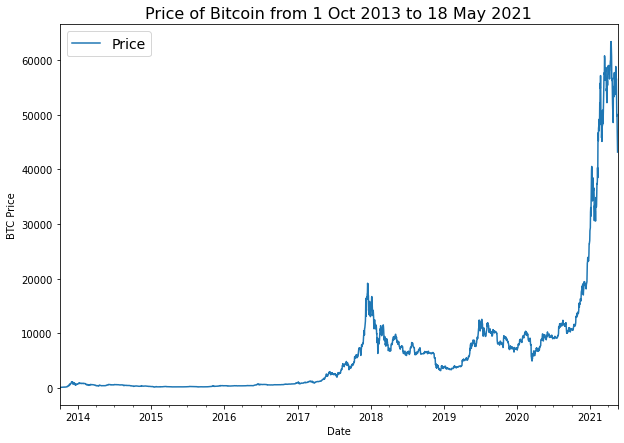

In [10]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

In [11]:
# Let's turn our DataFrame index and column into NumPy arrays.

# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

# 2 Train Test Split

In [12]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

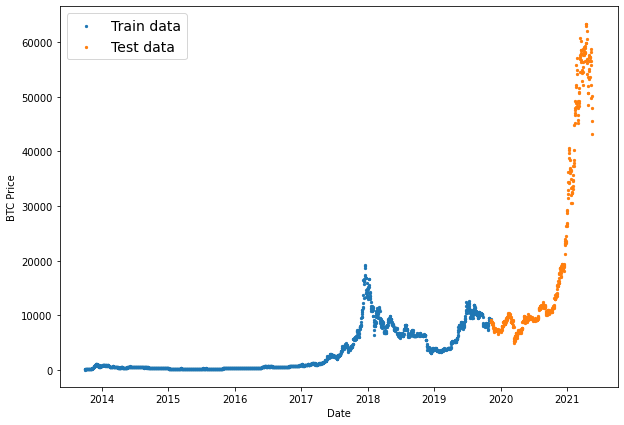

In [13]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

# 3 Naive Model

In [14]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value

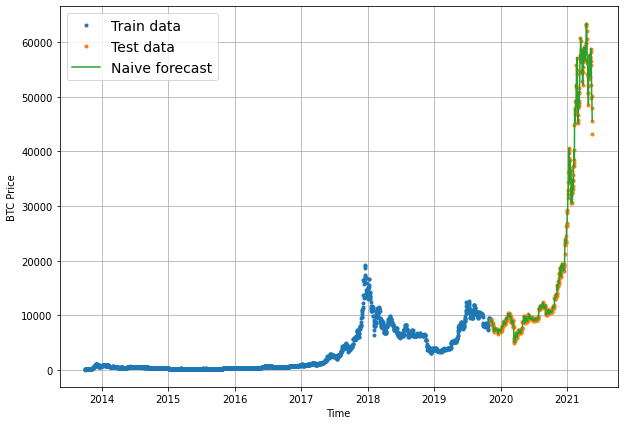

In [15]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

In [85]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': array(567.9802, dtype=float32),
 'mse': array(1147547.1, dtype=float32),
 'rmse': array(1071.2363, dtype=float32),
 'mape': array(0.02527042, dtype=float32),
 'mase': array(0.02837747, dtype=float32)}

# 4 Format Data Part 2: Windowing dataset

In [20]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [21]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

### Debug the function


In [22]:
# 1. Create a window of specific window_size (add the horizon on the end for later labelling)
window_size = 7
horizon =  1
window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
window_step

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])

In [23]:
window_indexes =\
window_step + np.expand_dims(np.arange(len(prices)-(window_size+horizon-1)), axis=0).T
window_indexes

array([[   0,    1,    2, ...,    8,    9,   10],
       [   1,    2,    3, ...,    9,   10,   11],
       [   2,    3,    4, ...,   10,   11,   12],
       ...,
       [2774, 2775, 2776, ..., 2782, 2783, 2784],
       [2775, 2776, 2777, ..., 2783, 2784, 2785],
       [2776, 2777, 2778, ..., 2784, 2785, 2786]])

In [24]:
# 3. Index on the target array (time series) with 2D array of multiple window steps
windowed_array = prices[window_indexes]
windowed_array[0:2]

array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116, 125.27966],
       [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
        123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ]])

In [25]:
# 4. Get the labelled windows
windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
windows[:3], labels[:2]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 ]]), array([[125.27966],
        [125.9275 ]]))

### Implament Function

In [59]:
full_windows, full_labels = make_windows(prices, window_size=7, horizon=1)
full_windows.shape, full_labels.shape

((2780, 7), (2780, 1))

In [60]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


# 5 Turn Window Into Train and Set Sets

In [61]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [62]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

# 6 Model 1 Dense Model Horizon 1, Window 7



In [63]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

We're going to start by keeping it simple, model_1 will have:

    A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
    An output layer with linear activation (or no activation)
    Adam optimizer and MAE loss function
    Batch size of 128
    100 epochs


### 6.1. Create the model

In [64]:
HIDDEN_UNITS = 128
BATCH_SIZE = 28
EPOCHS = 20
LR = 0.01

In [65]:
class DenseModel(nn.Module):

  def __init__(self, window_size: int, horizon: int, hidden_units : int) -> None:
    super().__init__()

    self.linear1 = nn.Linear(window_size, hidden_units)
    self.linear2 = nn.Linear(hidden_units, horizon)
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.relu(self.linear1(x))
    x = self.linear2(x)

    return x


In [66]:
model_1 = DenseModel(window_size = WINDOW_SIZE,
                     horizon = HORIZON,
                     hidden_units = HIDDEN_UNITS)

In [67]:
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = LR)
loss_fn = nn.MSELoss()

### 6.2 Get the data into DataLoaders

In [68]:
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(train_windows),torch.Tensor(train_labels))
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE)

test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_windows),torch.Tensor(test_labels))
test_dl = DataLoader(test_dataset, batch_size=len(test_dataset))

In [69]:
dat, lab = next(iter(train_dl))
print(dat[:4], '\n', lab[:3])

tensor([[123.6550, 125.4550, 108.5848, 118.6747, 121.3387, 120.6553, 121.7950],
        [125.4550, 108.5848, 118.6747, 121.3387, 120.6553, 121.7950, 123.0330],
        [108.5848, 118.6747, 121.3387, 120.6553, 121.7950, 123.0330, 124.0490],
        [118.6747, 121.3387, 120.6553, 121.7950, 123.0330, 124.0490, 125.9612]]) 
 tensor([[123.0330],
        [124.0490],
        [125.9612]])


### 6.3 Train the New Model

In [70]:
# check if shapes are ok
model_1(dat).shape

torch.Size([28, 1])

In [71]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss = 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    return train_loss

In [72]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss  =  0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    
    return test_loss

In [73]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "test_loss": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer)
        test_loss = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f} | "
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    # 6. Return the filled results at the end of the epochs
    return results


In [74]:

model_1_results = train(
    model = model_1,
    train_dataloader= train_dl,
    test_dataloader = test_dl,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = 10    )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 278324.2259 | test_loss: 2115940.7500 | 
Epoch: 2 | train_loss: 328578.0745 | test_loss: 7598459.5000 | 
Epoch: 3 | train_loss: 121089.4864 | test_loss: 1576090.7500 | 
Epoch: 4 | train_loss: 153239.3537 | test_loss: 1428424.0000 | 
Epoch: 5 | train_loss: 147204.6192 | test_loss: 1380623.8750 | 
Epoch: 6 | train_loss: 133696.9145 | test_loss: 1385192.0000 | 
Epoch: 7 | train_loss: 119070.4253 | test_loss: 1472247.1250 | 
Epoch: 8 | train_loss: 101185.7830 | test_loss: 1513366.1250 | 
Epoch: 9 | train_loss: 83772.1030 | test_loss: 1371558.2500 | 
Epoch: 10 | train_loss: 76206.9405 | test_loss: 1300954.8750 | 


In [75]:
test_data,test_labels = next(iter(test_dl))
model_1_preds = model_1(test_data).squeeze()

In [78]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 7.7 MB/s 


In [114]:
from torchmetrics import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError, WeightedMeanAbsolutePercentageError

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = torch.Tensor(y_true)
  y_pred = torch.Tensor(y_pred)

  # Calculate various metrics
  mean_absolute_error = MeanAbsoluteError()
  mean_squared_error = MeanSquaredError()
  mean_abs_percet_error = MeanAbsolutePercentageError()
  weighted_mape = WeightedMeanAbsolutePercentageError()

  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = torch.sqrt(mse)
  mape = mean_abs_percet_error(y_true, y_pred)
  mase =   weighted_mape(y_true, y_pred)
  
  return {"mae": mae.detach(),
          "mse": mse.detach(),
          "rmse": rmse.detach(),
          "mape": mape.detach(),
          "mase": mase.detach()}



In [115]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=torch.squeeze(test_labels), # reduce to right shape
                                 y_pred=torch.squeeze(model_1_preds))
naive_results, model_1_results

RuntimeError: ignored

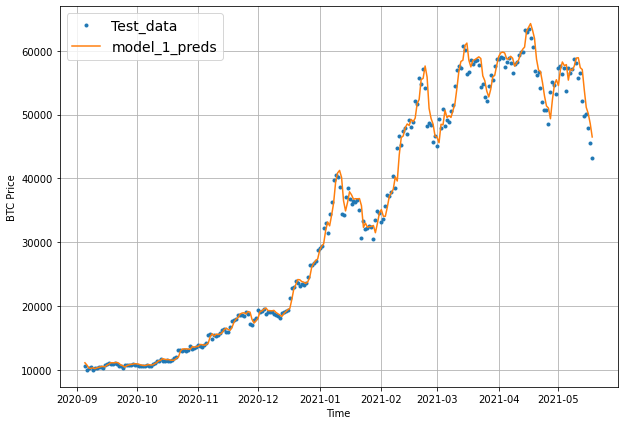

In [81]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds.detach(), start=offset, format="-", label="model_1_preds")

# 7 Model 2: Dense (window = 30, horizon = 1)

In [98]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [99]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)

train_dataset = torch.utils.data.TensorDataset(torch.Tensor(train_windows),torch.Tensor(train_labels))
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE)

test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_windows),torch.Tensor(test_labels))
test_dl = DataLoader(test_dataset, batch_size=len(test_dataset))

dat, lab = next(iter(train_dl))
print(dat[:4], '\n', lab[:3])

tensor([[123.6550, 125.4550, 108.5848, 118.6747, 121.3387, 120.6553, 121.7950,
         123.0330, 124.0490, 125.9612, 125.2797, 125.9275, 126.3833, 135.2420,
         133.2033, 142.7633, 137.9233, 142.9517, 152.5518, 160.3388, 164.3150,
         177.6333, 188.2972, 200.7017, 180.3550, 175.0317, 177.6965, 187.1598,
         192.7567, 197.4000],
        [125.4550, 108.5848, 118.6747, 121.3387, 120.6553, 121.7950, 123.0330,
         124.0490, 125.9612, 125.2797, 125.9275, 126.3833, 135.2420, 133.2033,
         142.7633, 137.9233, 142.9517, 152.5518, 160.3388, 164.3150, 177.6333,
         188.2972, 200.7017, 180.3550, 175.0317, 177.6965, 187.1598, 192.7567,
         197.4000, 196.0250],
        [108.5848, 118.6747, 121.3387, 120.6553, 121.7950, 123.0330, 124.0490,
         125.9612, 125.2797, 125.9275, 126.3833, 135.2420, 133.2033, 142.7633,
         137.9233, 142.9517, 152.5518, 160.3388, 164.3150, 177.6333, 188.2972,
         200.7017, 180.3550, 175.0317, 177.6965, 187.1598, 192.7567, 19

In [100]:
model_2 = DenseModel(window_size = WINDOW_SIZE,
                     horizon = HORIZON,
                     hidden_units = HIDDEN_UNITS)

optimizer = torch.optim.Adam(params = model_2.parameters(), lr = LR)
loss = nn.MSELoss()

In [101]:
model_2_results = train(
    model = model_2,
    train_dataloader= train_dl,
    test_dataloader = test_dl,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = EPOCHS)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3092663.2019 | test_loss: 98014624.0000 | 
Epoch: 2 | train_loss: 5784418.0275 | test_loss: 27784034.0000 | 
Epoch: 3 | train_loss: 3834402.0151 | test_loss: 8108430.0000 | 
Epoch: 4 | train_loss: 1438482.2493 | test_loss: 10156132.0000 | 
Epoch: 5 | train_loss: 1211547.9058 | test_loss: 9030189.0000 | 
Epoch: 6 | train_loss: 1573157.3419 | test_loss: 13231829.0000 | 
Epoch: 7 | train_loss: 1429693.9103 | test_loss: 9015144.0000 | 
Epoch: 8 | train_loss: 1705193.2871 | test_loss: 11266788.0000 | 
Epoch: 9 | train_loss: 1684042.0452 | test_loss: 5751353.5000 | 
Epoch: 10 | train_loss: 839517.4605 | test_loss: 6287958.5000 | 
Epoch: 11 | train_loss: 752167.6844 | test_loss: 5441677.5000 | 
Epoch: 12 | train_loss: 768187.2188 | test_loss: 7200145.0000 | 
Epoch: 13 | train_loss: 756275.7602 | test_loss: 6917985.5000 | 
Epoch: 14 | train_loss: 1012571.6841 | test_loss: 8215639.0000 | 
Epoch: 15 | train_loss: 1063547.1184 | test_loss: 5791499.5000 | 
Epoch: 16 | train_

In [102]:
test_data,test_labels = next(iter(test_dl))
model_2_preds = model_2(test_data).squeeze()

In [116]:
# Evaluate preds
model_2_results = evaluate_preds(y_true=torch.squeeze(test_labels), # reduce to right shape
                                 y_pred=torch.squeeze(model_2_preds))
model_2_results

{'mae': tensor(1600.1599),
 'mse': tensor(7170394.5000),
 'rmse': tensor(2677.7593),
 'mape': tensor(0.0718),
 'mase': tensor(0.0744)}

In [117]:
naive_results, model_1_results, model_2_results

({'mae': array(567.9802, dtype=float32),
  'mse': array(1147547.1, dtype=float32),
  'rmse': array(1071.2363, dtype=float32),
  'mape': array(0.02527042, dtype=float32),
  'mase': array(0.02837747, dtype=float32)},
 {'mae': array(610.93005, dtype=float32),
  'mse': array(1300954.9, dtype=float32),
  'rmse': array(1140.5941, dtype=float32),
  'mape': array(0.0273485, dtype=float32),
  'mase': array(0.03017771, dtype=float32)},
 {'mae': tensor(1600.1599),
  'mse': tensor(7170394.5000),
  'rmse': tensor(2677.7593),
  'mape': tensor(0.0718),
  'mase': tensor(0.0744)})

ValueError: ignored

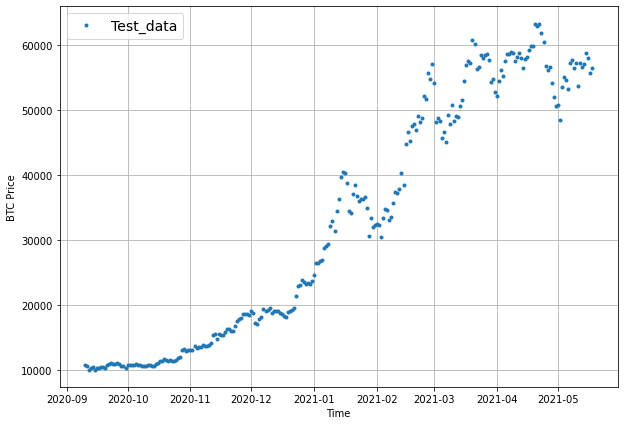

In [162]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds.detach(), start=offset, format="-", label="model_2_preds")

# 8 Model 3: Dense (window = 30, horizon = 7)

### 8.1 Prepare the data - Make windows, Split into train and test, Make datasets and dataloaders

In [120]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows.shape, full_labels.shape

((2751, 30), (2751, 7))

In [121]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2200, 30), (551, 30), (2200, 7), (551, 7))

In [122]:
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(train_windows),torch.Tensor(train_labels))
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE)

test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_windows),torch.Tensor(test_labels))
test_dl = DataLoader(test_dataset, batch_size=len(test_dataset))

dat, lab = next(iter(train_dl))
print(dat[:4], '\n', lab[:3])

tensor([[123.6550, 125.4550, 108.5848, 118.6747, 121.3387, 120.6553, 121.7950,
         123.0330, 124.0490, 125.9612, 125.2797, 125.9275, 126.3833, 135.2420,
         133.2033, 142.7633, 137.9233, 142.9517, 152.5518, 160.3388, 164.3150,
         177.6333, 188.2972, 200.7017, 180.3550, 175.0317, 177.6965, 187.1598,
         192.7567, 197.4000],
        [125.4550, 108.5848, 118.6747, 121.3387, 120.6553, 121.7950, 123.0330,
         124.0490, 125.9612, 125.2797, 125.9275, 126.3833, 135.2420, 133.2033,
         142.7633, 137.9233, 142.9517, 152.5518, 160.3388, 164.3150, 177.6333,
         188.2972, 200.7017, 180.3550, 175.0317, 177.6965, 187.1598, 192.7567,
         197.4000, 196.0250],
        [108.5848, 118.6747, 121.3387, 120.6553, 121.7950, 123.0330, 124.0490,
         125.9612, 125.2797, 125.9275, 126.3833, 135.2420, 133.2033, 142.7633,
         137.9233, 142.9517, 152.5518, 160.3388, 164.3150, 177.6333, 188.2972,
         200.7017, 180.3550, 175.0317, 177.6965, 187.1598, 192.7567, 19

### 8.2 Make new model

In [163]:
class DenseModel(nn.Module):

  def __init__(self, window_size: int, horizon: int, hidden_units : int) -> None:
    super().__init__()

    self.linear1 = nn.Linear(window_size, hidden_units)
    self.linear2 = nn.Linear(hidden_units, horizon)
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.relu(self.linear1(x))
    x = self.linear2(x)
    return x


In [164]:
model_3 = DenseModel(window_size = WINDOW_SIZE,
                     horizon = HORIZON,
                     hidden_units = HIDDEN_UNITS)

optimizer = torch.optim.Adam(params = model_3.parameters(), lr = LR)
loss = nn.MSELoss()

In [165]:
WINDOW_SIZE, HORIZON, BATCH_SIZE

(30, 7, 28)

In [166]:
s = model_3(next(iter(train_dl))[0])
s.shape

torch.Size([28, 7])

In [158]:
loss_fn(s, next(iter(train_dl))[1])

tensor(328655.7812, grad_fn=<MseLossBackward0>)

In [160]:
loss_fn(s.flatten(), next(iter(train_dl))[1].flatten())

tensor(328655.7812, grad_fn=<MseLossBackward0>)

In [167]:
model_3_results = train(
    epochs=20,
    model = model_3,
    train_dataloader = train_dl,
    test_dataloader = test_dl,
    optimizer = optimizer,
    loss_fn = loss_fn
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3209908.5674 | test_loss: 114830544.0000 | 
Epoch: 2 | train_loss: 3460876.5788 | test_loss: 32241556.0000 | 
Epoch: 3 | train_loss: 1548573.7633 | test_loss: 45149748.0000 | 
Epoch: 4 | train_loss: 2857282.8501 | test_loss: 22621896.0000 | 
Epoch: 5 | train_loss: 2459443.2874 | test_loss: 10511461.0000 | 
Epoch: 6 | train_loss: 1746751.1022 | test_loss: 10922551.0000 | 
Epoch: 7 | train_loss: 1090560.1756 | test_loss: 9290570.0000 | 
Epoch: 8 | train_loss: 931255.0784 | test_loss: 8886910.0000 | 
Epoch: 9 | train_loss: 893030.5519 | test_loss: 8998018.0000 | 
Epoch: 10 | train_loss: 894640.6380 | test_loss: 9148698.0000 | 
Epoch: 11 | train_loss: 912791.4041 | test_loss: 10002308.0000 | 
Epoch: 12 | train_loss: 1070721.2136 | test_loss: 9844768.0000 | 
Epoch: 13 | train_loss: 1161920.9062 | test_loss: 9435661.0000 | 
Epoch: 14 | train_loss: 1161994.1587 | test_loss: 9122036.0000 | 
Epoch: 15 | train_loss: 1278694.7393 | test_loss: 8260052.0000 | 
Epoch: 16 | tra

In [168]:
test_data,test_labels = next(iter(test_dl))
model_3_preds = model_3(test_data).squeeze()

# Evaluate preds
model_3_results = evaluate_preds(y_true=torch.squeeze(test_labels), # reduce to right shape
                                 y_pred=torch.squeeze(model_3_preds))
model_3_results

{'mae': tensor(1784.5125),
 'mse': tensor(9323457.),
 'rmse': tensor(3053.4336),
 'mape': tensor(0.0812),
 'mase': tensor(0.0858)}

In [175]:
model_3_preds.shape, test_labels.shape

(torch.Size([551, 7]), torch.Size([551, 7]))

In [170]:
model_3_results, model_2_results

({'mae': tensor(1784.5125),
  'mse': tensor(9323457.),
  'rmse': tensor(3053.4336),
  'mape': tensor(0.0812),
  'mase': tensor(0.0858)},
 {'mae': tensor(1600.1599),
  'mse': tensor(7170394.5000),
  'rmse': tensor(2677.7593),
  'mape': tensor(0.0718),
  'mase': tensor(0.0744)})

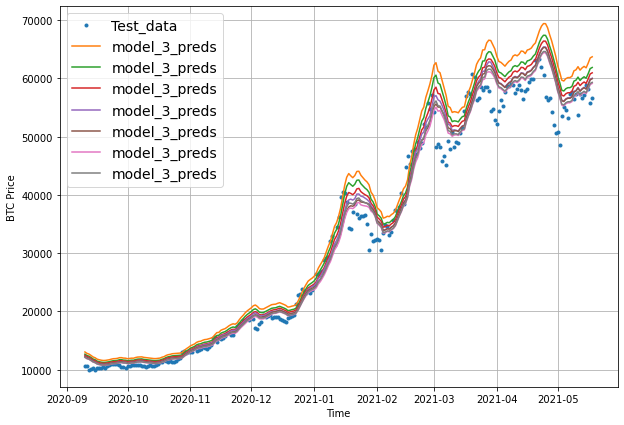

In [171]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds.detach(), start=offset, format="-", label="model_3_preds")

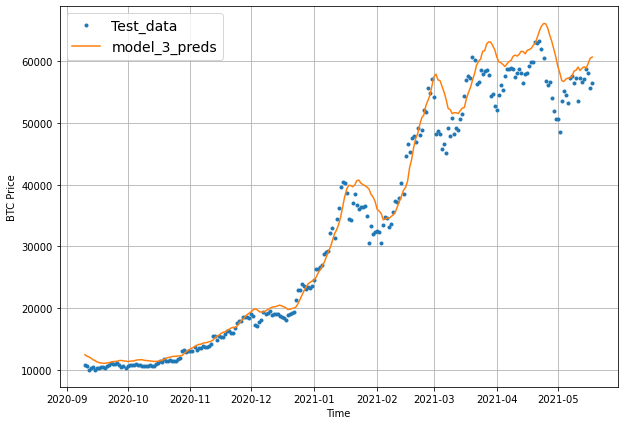

In [180]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=torch.mean(model_3_preds.detach(), axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")



In [189]:
{"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}

{'naive': array(567.9802, dtype=float32),
 'horizon_1_window_7': array(610.93005, dtype=float32),
 'horizon_1_window_30': tensor(1600.1599),
 'horizon_7_window_30': tensor(1784.5125)}

# 9 Model 4: Conv1D